In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import sklearn
from scipy.sparse import load_npz
import pickle
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

In [ ]:
from sklearn.linear_model import LogisticRegression

# Load data

In [ ]:
data_folder_path = "/content/drive/MyDrive/COMP30027/Assignment/data/ver1"
train_filename = 'recipe_train.csv'
test_filename = 'recipe_test.csv'

train_path = os.path.join(data_folder_path, train_filename)
test_path = os.path.join(data_folder_path, test_filename)

train_df = 	pd.read_csv(train_path, index_col = False, delimiter = ',', header=None)
train_df.rename(columns=train_df.iloc[0], inplace = True)
train_df.drop([0], inplace = True)
pd.set_option('display.max_colwidth', None)
train_df.head()

,name,n_steps,n_ingredients,steps,ingredients,duration_label
1,wi gal s chicken rice stove top dish made healthier,6,12,"['in saucepan , melt margarine and combine with olive oil', 'add celery & onion and saute until tender', 'add garlic for the last minute', 'add carrots , broth , rice and pepper and bring to a boil', 'reduce heat , cover , and simmer for 35 minutes , or until rice is tender', 'stir in chicken and parsley , cover , and simmer for 5 minutes longer or until heated through']","['margarine', 'olive oil', 'celery', 'onion', 'garlic clove', 'carrots', 'low sodium chicken broth', 'brown rice', 'pepper', 'salt substitute', 'boneless skinless chicken breasts', 'fresh parsley']",2.0
2,irish pin oats,9,5,"['melt 1 tbs butter in a small saucepan over med high heat', 'when the butter stops foaming , add the oats and stir well for 1 minute', 'reduce heat to low , and let the oats cook for 1 more minute', 'add the water , stir and place the lid on tightly', 'allow to simmer for 20 minutes , or until the majority of the water is absorbed', 'add the half and half and turn off the heat', 'replace the lid and allow to sit for 5 minutes', 'add the remaining 2 tbs butter and salt to taste', 'brown sugar and cinnamon may be added if you prefer sweet oats']","['butter', 'pinhead oats', 'water', 'half-and-half', 'salt']",2.0
3,cheesy beef n biscuit casserole,15,10,"['brown ground beef , onion and green pepper', 'drain', 'stir tomato sauce , chili powder and garlic salt', 'simmer while preparing dough', 'separate biscuit dough into 10 biscuits', 'pull each apart into 2 layers', 'press 10 biscuit layers over bottom of ungreased 9 inch baking pan', 'combine 1 / 2 cup cheese , sour cream and egg', 'mix well', 'remove meat mixture from heat', 'stir in sour cream mixture', 'spoon over biscuits', 'arrange remaining biscuit layers on top', 'sprinkle with remaining cheese', 'bake at 375 degrees for 30 to 35 minutes or until biscuits are a deep golden brown']","['ground beef', 'onion', 'green pepper', 'tomato sauce', 'chili powder', 'garlic salt', 'refrigerated biscuits', 'cheddar cheese', 'sour cream', 'egg']",2.0
4,lemonade chicken oamc,10,8,"['brown chicken in oil', 'combine all ingredients except cornstarch and bring to a boil', 'reduce heat', 'cover and simmer about 40 minutes until tender', 'combine cornstarch with 1 / 2 cup cold water and mix until blended', 'stir mixture into chicken mixture until thick and bubbly', 'allow to cool if you want to freeze it', 'if frozen , may need a little extra water when reheating', 'serve over rice or noodles', 'great with frozen green beans mixed in !']","['boneless skinless chicken', 'frozen lemonade', 'oil', 'catsup', 'vinegar', 'water', 'brown sugar', 'cornstarch']",2.0
5,graham and peanut butter bon bons,6,5,"['set almond bark aside', 'mix remaining ingredients together in a bowl', 'refrigerate for 1 hour', 'melt almond bark', 'form crumb mixture into balls and dip in melted almond bark , place on waxed paper', 'allow the almond bark to cool and set up']","['graham cracker crumbs', 'crunchy peanut butter', 'powdered sugar', 'crisp rice cereal', 'almond bark']",2.0


In [ ]:
metadata = train_df[["n_steps", "n_ingredients","duration_label"]].copy()
metadata["duration_label"] = [int(float(x)) for x in list(metadata["duration_label"].values) ]
metadata["n_ingredients"] = [int(float(x)) for x in list(metadata["n_ingredients"].values) ]
metadata["n_steps"] = [int(float(x)) for x in list(metadata["n_steps"].values) ]
metadata.head()

,n_steps,n_ingredients,duration_label
1,6,12,2
2,9,5,2
3,15,10,2
4,10,8,2
5,6,5,2


In [ ]:
metadata.corr()

,n_steps,n_ingredients,duration_label
n_steps,1.000000,0.409603,0.279366
n_ingredients,0.409603,1.000000,0.271702
duration_label,0.279366,0.271702,1.000000


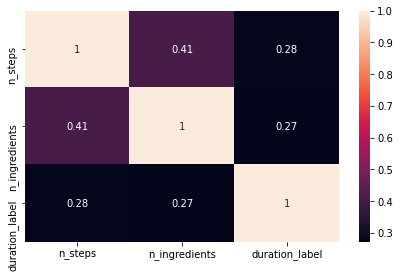

In [ ]:
corr = metadata.corr()
ax = sns.heatmap(
    corr, annot = True
)

plt.tight_layout()

plt.savefig("metadata.png")
plt.show()

# Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(metadata[["n_steps", "n_ingredients"]], metadata["duration_label"] , test_size=0.1, random_state=42)
model = LogisticRegression(random_state=42,  max_iter = 100000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, labels= model.classes_))

              precision    recall  f1-score   support

           1       0.61      0.67      0.64      1763
           2       0.67      0.68      0.67      2038
           3       0.00      0.00      0.00       199

    accuracy                           0.64      4000
   macro avg       0.43      0.45      0.44      4000
weighted avg       0.61      0.64      0.63      4000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', "sag","saga"]
penalty = ['l2']
c_values = [100,10, 1.0, 0.1, 0.01, 0.001]
max_iter = [10000]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter = max_iter)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='f1_micro',error_score=0)
grid_result = grid_search.fit(metadata[["n_steps", "n_ingredients"]],  metadata["duration_label"])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.637000 using {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.637000 (0.004889) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.637000 (0.004889) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.637000 (0.004889) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'sag'}
0.637000 (0.004889) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
0.637000 (0.004889) with: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.637000 (0.004889) with: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.637000 (0.004889) with: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'sag'}
0.637000 (0.004889) with: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
0.637000 (0.004889) with: {'C': 1.0, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.637000 (0.004889) with: {'C': 1.0, 'max_iter': 10000, 'penalty': 'l2', 'solve

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
param_grid = {
    'max_depth': [1,2,3,2,5,6,10, 50, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
}
# Create a based model
rf = DecisionTreeClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                        n_jobs = -1)
grid_search.fit(metadata[["n_steps", "n_ingredients"]],  metadata["duration_label"])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.637000 using {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.637000 (0.004889) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.637000 (0.004889) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.637000 (0.004889) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'sag'}
0.637000 (0.004889) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
0.637000 (0.004889) with: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.637000 (0.004889) with: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.637000 (0.004889) with: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'sag'}
0.637000 (0.004889) with: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
0.637000 (0.004889) with: {'C': 1.0, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.637000 (0.004889) with: {'C': 1.0, 'max_iter': 10000, 'penalty': 'l2', 'solve